# Evaluation Method

In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Load Model

In [41]:
output_df=pd.read_csv('sentiment_data/sentiments_final.csv')

In [42]:
output_df.sort_values(by='date', ascending=True, inplace=True)
display(output_df.head())
display(output_df.tail())

,date,finBert,finBert_finbert_label,GGBert_finbert_label,finBert_return_next_label,GGBert_return_next_label
0,2023-11-01,negative,negative,negative,positive,positive
1,2023-11-02,positive,positive,positive,positive,negative
2,2023-11-03,negative,negative,negative,positive,positive
3,2023-11-06,negative,negative,negative,neutral,neutral
4,2023-11-07,positive,positive,positive,positive,positive


,date,finBert,finBert_finbert_label,GGBert_finbert_label,finBert_return_next_label,GGBert_return_next_label
367,2025-04-24,neutral,neutral,neutral,positive,positive
368,2025-04-25,negative,negative,negative,positive,positive
369,2025-04-28,negative,negative,negative,positive,positive
370,2025-04-29,negative,negative,negative,positive,positive
371,2025-04-30,negative,negative,negative,positive,positive


### Choose Stock

In [43]:
stock = "^SPX"
stock_df = yf.download(stock, start="2023-01-01", end="2025-05-01", multi_level_index=False)

[*********************100%***********************]  1 of 1 completed

In [44]:
stock_df = stock_df['Close'].to_frame().reset_index()

display(stock_df.head())
display(stock_df.shape)

,Date,Close
0,2023-01-03,3824.139893
1,2023-01-04,3852.969971
2,2023-01-05,3808.100098
3,2023-01-06,3895.080078
4,2023-01-09,3892.090088


(583, 2)

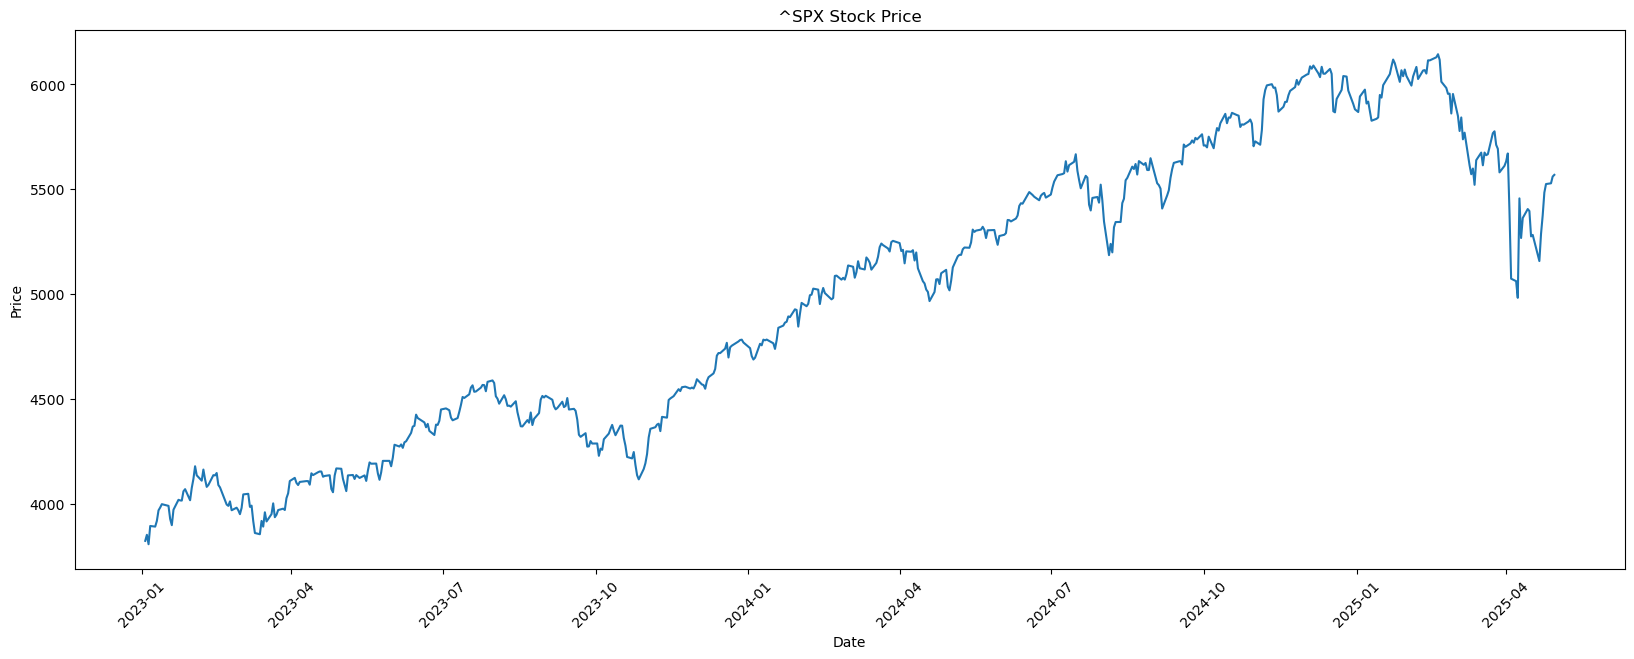

In [45]:
plt.figure(figsize=(20, 7))
plt.plot(stock_df['Date'], stock_df['Close'])
plt.title(f"{stock} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

In [46]:
stock_df['pct_change'] = stock_df['Close'].pct_change()
stock_df['pct_change'] = stock_df['pct_change'].shift(-1)
stock_df['pct_change'] = stock_df['pct_change'].fillna(0)
display(stock_df.head())
display(stock_df.tail())

,Date,Close,pct_change
0,2023-01-03,3824.139893,0.007539
1,2023-01-04,3852.969971,-0.011646
2,2023-01-05,3808.100098,0.022841
3,2023-01-06,3895.080078,-0.000768
4,2023-01-09,3892.090088,0.006978


,Date,Close,pct_change
578,2025-04-24,5484.770020,0.007373
579,2025-04-25,5525.209961,0.000641
580,2025-04-28,5528.750000,0.005802
581,2025-04-29,5560.830078,0.001480
582,2025-04-30,5569.060059,0.000000


In [47]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
output_df['date'] = pd.to_datetime(output_df['date'])

In [48]:
#Merge the stock data with the model dataframes
df = pd.merge(output_df, stock_df, left_on='date', right_on='Date', how='left')

In [49]:
df.drop(columns=['Date'], inplace=True)

In [68]:
display(df.head())

,date,finBert,finBert_finbert_label,GGBert_finbert_label,finBert_return_next_label,GGBert_return_next_label,Close,pct_change,SMA_20,SMA_50,...,FinBERT_finbert_label_cumulative,GGBert_finbert_label_cumulative,FinBERT_return_next_label_cumulative,GGBert_return_next_label_cumulative,BuyHold_Cumulative,SMA_Cumulative,RSI_Cumulative,MACD_Cumulative,BB_Cumulative,MA_5
0,2023-11-01,-1,-1,-1,1,1,4237.859863,0.018859,NaN,NaN,...,0.981141,0.981141,1.018859,1.018859,1.018859,1.0,1.0,1.0,1.0,NaN
1,2023-11-02,1,1,1,1,-1,4317.779785,0.009394,NaN,NaN,...,0.990358,0.990358,1.028429,1.009288,1.028429,1.0,1.0,1.0,1.0,NaN
2,2023-11-03,-1,-1,-1,1,1,4358.339844,0.001753,NaN,NaN,...,0.988622,0.988622,1.030232,1.011057,1.030232,1.0,1.0,1.0,1.0,NaN
3,2023-11-06,-1,-1,-1,0,0,4365.979980,0.002840,NaN,NaN,...,0.985814,0.985814,1.030232,1.011057,1.033158,1.0,1.0,1.0,1.0,NaN
4,2023-11-07,1,1,1,1,1,4378.379883,0.001005,NaN,NaN,...,0.986805,0.986805,1.031268,1.012073,1.034196,1.0,1.0,1.0,1.0,4331.667871


In [51]:
#change sentiment string to -1,0,1
def sentiment_to_numeric(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'neutral':
        return 0
    elif sentiment == 'positive':
        return 1
    else:
        return np.nan

df['finBert'] = df['finBert'].apply(sentiment_to_numeric)
df['finBert_finbert_label'] = df['finBert_finbert_label'].apply(sentiment_to_numeric)
df['GGBert_finbert_label'] = df['GGBert_finbert_label'].apply(sentiment_to_numeric)
df['finBert_return_next_label'] = df['finBert_return_next_label'].apply(sentiment_to_numeric)
df['GGBert_return_next_label'] = df['GGBert_return_next_label'].apply(sentiment_to_numeric)

In [52]:
df.dropna(inplace=True)
display(df.head())

,date,finBert,finBert_finbert_label,GGBert_finbert_label,finBert_return_next_label,GGBert_return_next_label,Close,pct_change
0,2023-11-01,-1,-1,-1,1,1,4237.859863,0.018859
1,2023-11-02,1,1,1,1,-1,4317.779785,0.009394
2,2023-11-03,-1,-1,-1,1,1,4358.339844,0.001753
3,2023-11-06,-1,-1,-1,0,0,4365.979980,0.002840
4,2023-11-07,1,1,1,1,1,4378.379883,0.001005


## 1. Correlation

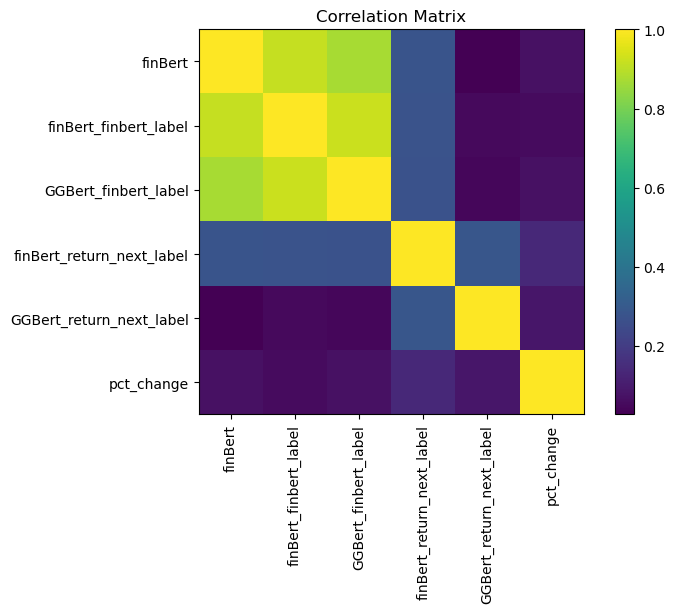

In [53]:
correlation_df=df[['finBert','finBert_finbert_label','GGBert_finbert_label','finBert_return_next_label','GGBert_return_next_label','pct_change',]].copy()
correlation_df = correlation_df.corr()

plt.figure(figsize=(8, 5))
plt.title("Correlation Matrix")
plt.imshow(correlation_df, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_df.columns)), correlation_df.columns, rotation=90)
plt.yticks(range(len(correlation_df.columns)), correlation_df.columns)
plt.grid(False)
plt.show()

In [54]:
fig = px.imshow(correlation_df, text_auto=True, aspect="auto", color_continuous_scale='RdBu', title="Correlation Matrix")
fig.update_xaxes(title_text="Features")
fig.show()

## 2. Techincal Analysis

### Simple Moving Average

In [55]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

df['sma_signal'] = 0
df.loc[df['SMA_20'] > df['SMA_50'], 'sma_signal'] = 1
df.loc[df['SMA_20'] < df['SMA_50'], 'sma_signal'] = -1

### RSI

In [56]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

df['rsi_signal'] = 0
df.loc[df['RSI'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI'] > 70, 'rsi_signal'] = -1

### MACD

In [57]:
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

df['macd_signal_line'] = 0
df.loc[df['MACD'] > df['MACD_signal'], 'macd_signal_line'] = 1
df.loc[df['MACD'] < df['MACD_signal'], 'macd_signal_line'] = -1

### Bollinger Bands

In [58]:
bb = ta.volatility.BollingerBands(df['Close'])
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()

df['bb_signal'] = 0
df.loc[df['Close'] < df['bb_lower'], 'bb_signal'] = 1
df.loc[df['Close'] > df['bb_upper'], 'bb_signal'] = -1

In [59]:
df['sma_return']=df['sma_signal'].shift(1)*df['pct_change']
df['RSI_return']=df['rsi_signal'].shift(1)*df['pct_change']
df['MACD_return']=df['macd_signal_line'].shift(1)*df['pct_change']
df['BB_return']=df['bb_signal'].shift(1)*df['pct_change']

In [60]:
df['Next_Close'] = df['Close'].shift(-1)
df['Return'] = (df['Next_Close'] - df['Close']) / df['Close']

df['Strategy_Return_FinBERT'] = df['finBert'].shift(0) * df['Return']
df['Strategy_Return_FinBERT_finbert_label'] = df['finBert_finbert_label'].shift(0) * df['Return']
df['Strategy_Return_GGBert_finbert_label'] = df['GGBert_finbert_label'].shift(0) * df['Return']
df['Srategy_Return_FinBERT_return_next_label'] = df['finBert_return_next_label'].shift(0) * df['Return']
df['Strategy_Return_GGBert_return_next_label'] = df['GGBert_return_next_label'].shift(0) * df['Return']

df['FinBERT_cumulative'] = (1 + df['Strategy_Return_FinBERT'].fillna(0)).cumprod()
df['FinBERT_finbert_label_cumulative'] = (1 + df['Strategy_Return_FinBERT_finbert_label'].fillna(0)).cumprod()
df['GGBert_finbert_label_cumulative'] = (1 + df['Strategy_Return_GGBert_finbert_label'].fillna(0)).cumprod()
df['FinBERT_return_next_label_cumulative'] = (1 + df['Srategy_Return_FinBERT_return_next_label'].fillna(0)).cumprod()
df['GGBert_return_next_label_cumulative'] = (1 + df['Strategy_Return_GGBert_return_next_label'].fillna(0)).cumprod()
df['BuyHold_Cumulative'] = (1 + df['Return'].fillna(0)).cumprod()
df['SMA_Cumulative'] = (1 + df['sma_return'].fillna(0)).cumprod()
df['RSI_Cumulative'] = (1 + df['RSI_return'].fillna(0)).cumprod()
df['MACD_Cumulative'] = (1 + df['MACD_return'].fillna(0)).cumprod()
df['BB_Cumulative'] = (1 + df['BB_return'].fillna(0)).cumprod()

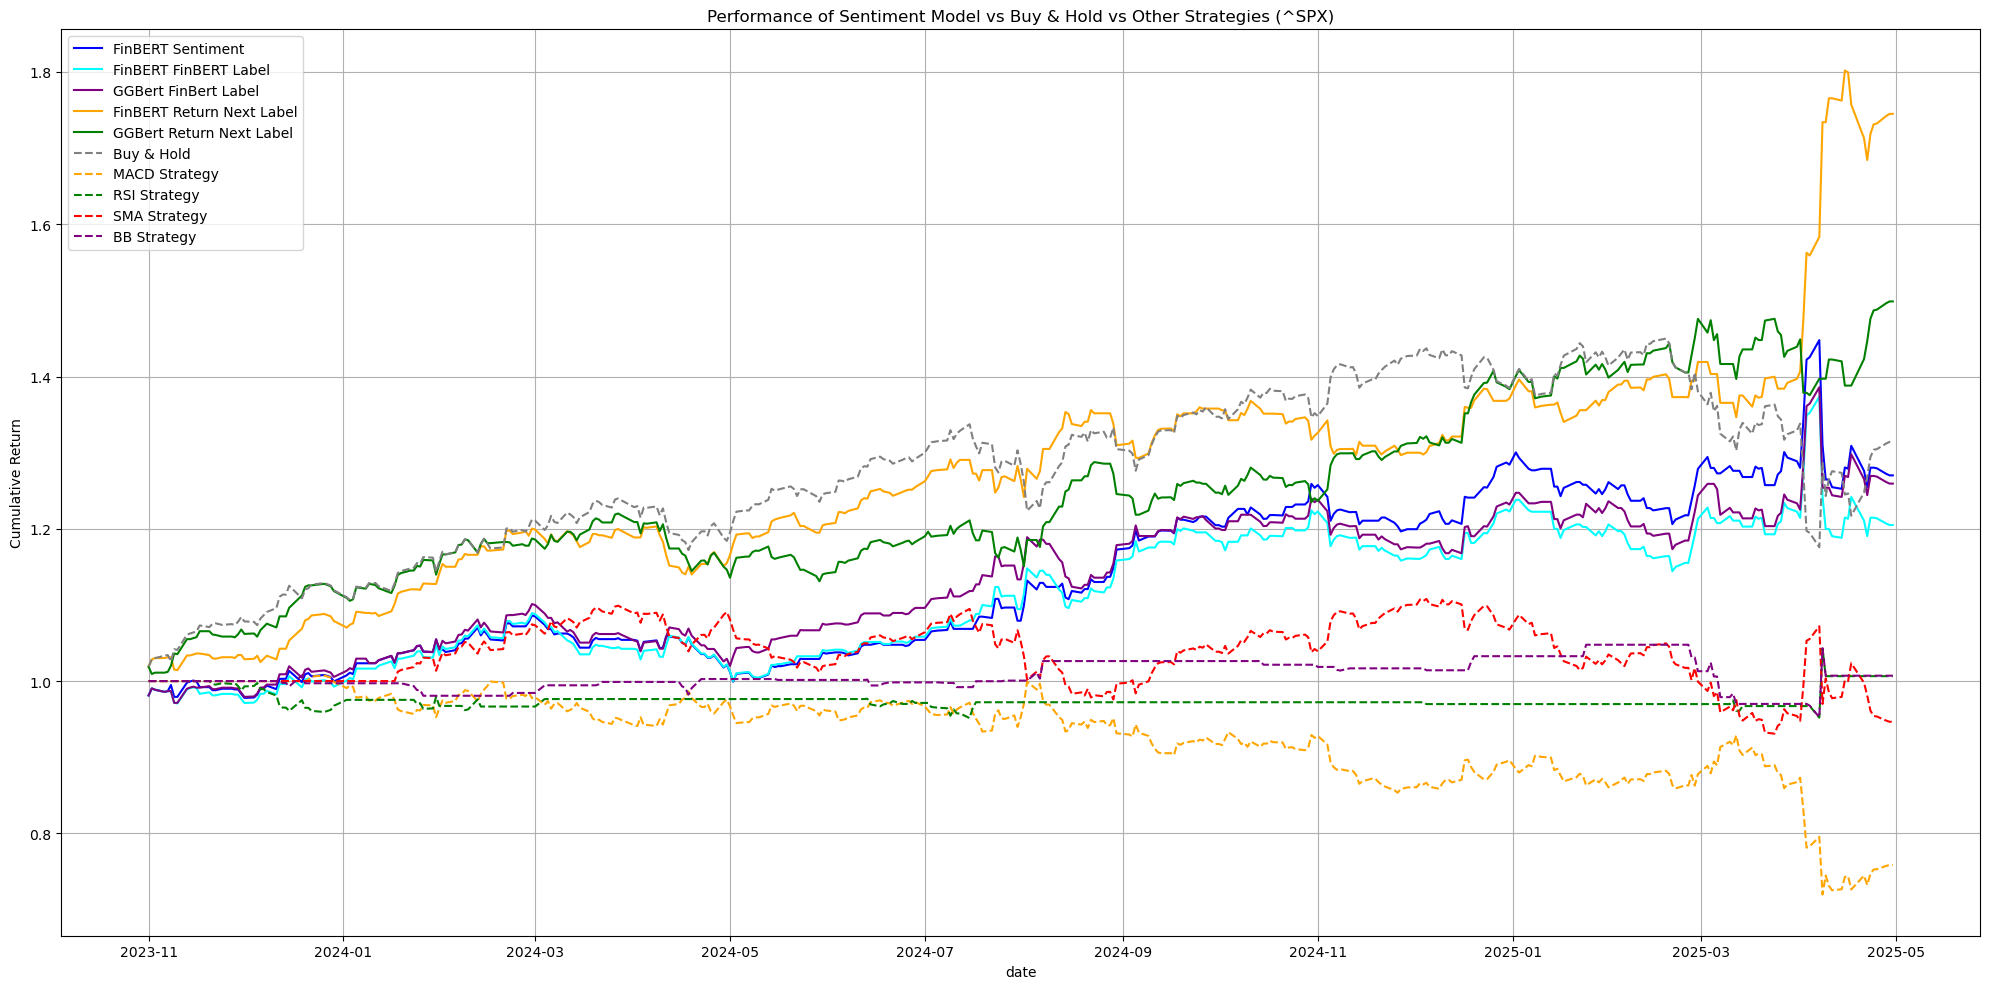

In [61]:
plt.figure(figsize=(20, 10))

plt.plot(df['date'], df['FinBERT_cumulative'], label='FinBERT Sentiment', color='blue')
plt.plot(df['date'], df['FinBERT_finbert_label_cumulative'], label='FinBERT FinBERT Label', color='cyan')
plt.plot(df['date'], df['GGBert_finbert_label_cumulative'], label='GGBert FinBert Label', color='purple')
plt.plot(df['date'], df['FinBERT_return_next_label_cumulative'], label='FinBERT Return Next Label', color='orange')
plt.plot(df['date'], df['GGBert_return_next_label_cumulative'], label='GGBert Return Next Label', color='green')
plt.plot(df['date'], df['BuyHold_Cumulative'], label='Buy & Hold', linestyle='--', color='gray')
plt.plot(df['date'], df['MACD_Cumulative'], label='MACD Strategy', linestyle='--', color='orange')
plt.plot(df['date'], df['RSI_Cumulative'], label='RSI Strategy', linestyle='--', color='green')
plt.plot(df['date'], df['SMA_Cumulative'], label='SMA Strategy', linestyle='--', color='red')
plt.plot(df['date'], df['BB_Cumulative'], label='BB Strategy', linestyle='--', color='purple')
plt.title(f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({stock})")
plt.xlabel("date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
import plotly.express as px
fig = px.line(df, x='date', y=['FinBERT_cumulative', 'FinBERT_finbert_label_cumulative', 'GGBert_finbert_label_cumulative', 'FinBERT_return_next_label_cumulative', 'GGBert_return_next_label_cumulative', 'BuyHold_Cumulative', 'SMA_Cumulative', 'RSI_Cumulative', 'MACD_Cumulative', 'BB_Cumulative'], title=f"Performance of Sentiment Model vs Buy & Hold vs Other Strategies ({stock})")
fig.update_traces(mode='lines', hovertemplate='%{x}<br>%{y:.2f}')
fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()

In [63]:
def simulate_trading_strategy(x):
    initial_balance = 1000000
    capital = initial_balance
    position = 0

    for i in range(len(df)):
        if df[x][i] == 1 and position == 0:
            position = capital / df["Close"][i]
            capital = 0
            #print(f"Buying at {df['Close'][i]} on {df['date'][i]}")
        elif df[x][i] == -1 and position > 0:
            capital = position * df["Close"][i]
            position = 0
            #print(f"Selling at {df['Close'][i]} on {df['date'][i]}")
        elif df[x][i] == 0:
            #print(f"Holding at {df['Close'][i]} on {df['date'][i]}")
            pass

    final_value = capital if capital > 0 else position * df["Close"].iloc[-1]
    returns = (final_value - initial_balance) / initial_balance * 100
    print(f"Strategy from: {x}")
    print(f"Profit/Loss: {final_value - initial_balance:.2f}")
    print(f"Portfolio Return: {returns:.2f}% from {initial_balance} to {final_value:.2f} over {len(df)} days\n")

In [64]:
simulate_trading_strategy('finBert')
simulate_trading_strategy('finBert_finbert_label')
simulate_trading_strategy('GGBert_finbert_label')
simulate_trading_strategy('finBert_return_next_label')
simulate_trading_strategy('GGBert_return_next_label')

Strategy from: finBert
Profit/Loss: 400319.25
Portfolio Return: 40.03% from 1000000 to 1400319.25 over 372 days

Strategy from: finBert_finbert_label
Profit/Loss: 338636.50
Portfolio Return: 33.86% from 1000000 to 1338636.50 over 372 days

Strategy from: GGBert_finbert_label
Profit/Loss: 307621.54
Portfolio Return: 30.76% from 1000000 to 1307621.54 over 372 days

Strategy from: finBert_return_next_label
Profit/Loss: 463264.86
Portfolio Return: 46.33% from 1000000 to 1463264.86 over 372 days

Strategy from: GGBert_return_next_label
Profit/Loss: 315844.28
Portfolio Return: 31.58% from 1000000 to 1315844.28 over 372 days



In [65]:
simulate_trading_strategy('sma_signal')
simulate_trading_strategy('rsi_signal')
simulate_trading_strategy('macd_signal_line')
simulate_trading_strategy('bb_signal')

Strategy from: sma_signal
Profit/Loss: 86471.21
Portfolio Return: 8.65% from 1000000 to 1086471.21 over 372 days

Strategy from: rsi_signal
Profit/Loss: -8103.93
Portfolio Return: -0.81% from 1000000 to 991896.07 over 372 days

Strategy from: macd_signal_line
Profit/Loss: 22904.34
Portfolio Return: 2.29% from 1000000 to 1022904.34 over 372 days

Strategy from: bb_signal
Profit/Loss: 152471.79
Portfolio Return: 15.25% from 1000000 to 1152471.79 over 372 days



In [66]:
df["MA_5"] = df["Close"].rolling(window=5).mean()

finBert_corr = df["finBert"].corr(df["pct_change"])
finBert_finbert_label_corr = df["finBert_finbert_label"].corr(df["pct_change"])
GGBert_finbert_label_corr = df["GGBert_finbert_label"].corr(df["pct_change"])
finBert_return_next_label_corr = df["finBert_return_next_label"].corr(df["pct_change"])
GGBert_return_next_label_corr = df["GGBert_return_next_label"].corr(df["pct_change"])
ma_corr = df["MA_5"].corr(df["pct_change"])
sma_corr = df["SMA_20"].corr(df["pct_change"])
rsi_corr = df["RSI"].corr(df["pct_change"])
macd_corr = df["MACD"].corr(df["pct_change"])
bb_corr = df["bb_upper"].corr(df["pct_change"])

print(f"FinBERT Correlation: {finBert_corr:.2f}")
print(f"FinBERT FinBERT Label Correlation: {finBert_finbert_label_corr:.2f}")
print(f"GGBert FinBERT Label Correlation: {GGBert_finbert_label_corr:.2f}")
print(f"FinBERT Return Next Label Correlation: {finBert_return_next_label_corr:.2f}")
print(f"GGBert Return Next Label Correlation: {GGBert_return_next_label_corr:.2f}")
print(f"Moving Average Correlation: {ma_corr:.2f}")
print(f"SMA Correlation: {sma_corr:.2f}")
print(f"RSI Correlation: {rsi_corr:.2f}")
print(f"MACD Correlation: {macd_corr:.2f}")
print(f"Bollinger Bands Correlation: {bb_corr:.2f}")

FinBERT Correlation: 0.07
FinBERT FinBERT Label Correlation: 0.06
GGBert FinBERT Label Correlation: 0.07
FinBERT Return Next Label Correlation: 0.14
GGBert Return Next Label Correlation: 0.08
Moving Average Correlation: -0.11
SMA Correlation: -0.09
RSI Correlation: -0.05
MACD Correlation: -0.06
Bollinger Bands Correlation: -0.07


In [67]:
initial_price = df["Close"].iloc[0]
final_price = df["Close"].iloc[-1]

buy_hold_return = (final_price - initial_price) / initial_price * 100

print(f"Buy & Hold Return: {buy_hold_return:.2f}%")

Buy & Hold Return: 31.41%
